# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import csv
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

# Various image-processing utils
from utils.image import generate_images, load_test_images, transform
from utils.plot import plot_distribution, plot_learing_progress, \
    plot_probabilities, plot_test_images, plot_train_images
from utils.utils import get_classes
# Net
from net.net import net

print(tf.__version__)
np.random.seed(seed=42)

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = np.array(train['features']), np.array(train['labels'])
X_valid, y_valid = np.array(valid['features']), np.array(valid['labels'])
X_test, y_test = np.array(test['features']), np.array(test['labels'])

0.12.1


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = len(y_train)
# Number of testing examples
n_test = len(y_test)
# Shape of an traffic sign image
image_shape = X_train.shape
# Number of unique classes/labels there are in the dataset
n_classes = len(np.unique(y_train))

print("""
Number of training examples: {}
Number of testing examples: {}
Shape of an traffic sign image: {}
Number of classes: {}
""".format(n_train, n_test, image_shape, n_classes))


Number of training examples: 34799
Number of testing examples: 12630
Shape of an traffic sign image: (34799, 32, 32, 3)
Number of classes: 43



### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

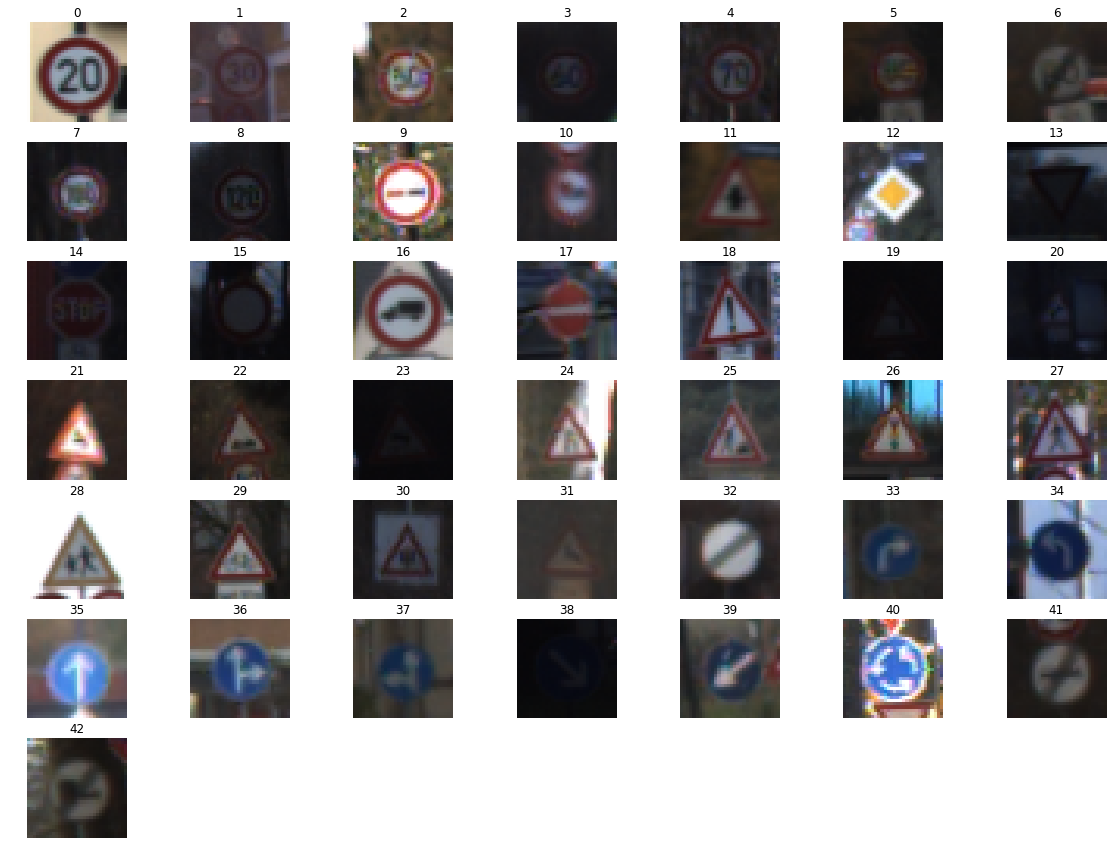

In [3]:
plot_train_images(X_train, y_train, n_classes)

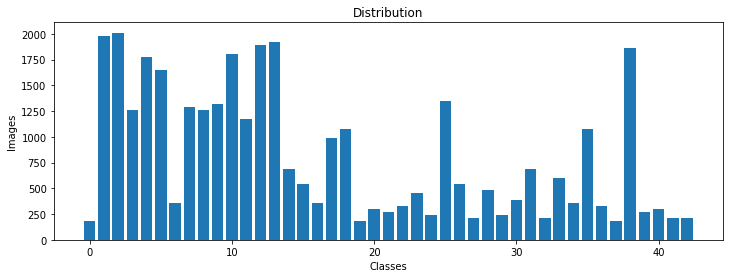

In [3]:
plot_distribution(X_train, y_train, n_classes)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.


Train dataset size: 27839
Validation dataset size: 6960
Number of images in the augmented dataset: 55678
X_train_aug shape: (55678, 32, 32, 3), y_train_aug shape: (55678,)



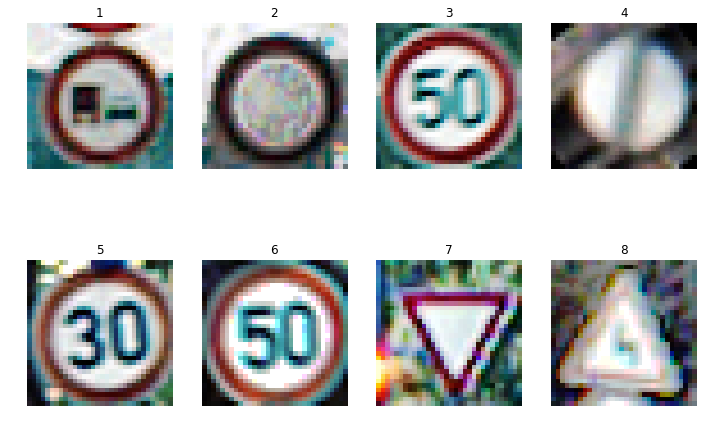

In [4]:
# Data preparing
TRAIN_SIZE = 0.8
train_size = int(TRAIN_SIZE * n_train)
mask = np.random.permutation(np.arange(n_train))[:train_size]
X_train_sub, y_train_sub = X_train[mask], y_train[mask]
X_val, y_val = np.delete(X_train, mask, 0), np.delete(y_train, mask, 0)
X_train_aug, y_train_aug, X_val_prep = generate_images(X_train_sub, y_train_sub, X_val, y_val)
X_test = np.array([transform(img) for img in X_test])

print("""
Train dataset size: {}
Validation dataset size: {}
Number of images in the augmented dataset: {}
X_train_aug shape: {}, y_train_aug shape: {}
""".format(len(y_train_sub), len(y_val), len(X_train_aug), X_train_aug.shape, y_train_aug.shape))

# Plot some random images from dataset we generated
plot_test_images(X_train_aug[np.random.choice(1000, 8)], name='generated')

### Model Architecture

![title](out/net.png)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [5]:
EPOCHS = 12
BATCH_SIZE = 128
BASE_RATE = 0.001

rate = BASE_RATE
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

logits = net(x, keep_prob, n_classes)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

In [6]:
def evaluate(X_data, y_data, sess):    
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.0 })
        total_accuracy += accuracy * len(batch_x)
        total_loss += loss * len(batch_x)
    return total_accuracy / num_examples, total_loss / num_examples

In [6]:
def train():
    global X_train_aug
    global y_train_aug
    global keep_prob
    global rate
    global BATCH_SIZE
    
    best_acc = 0
    
    with tf.Session() as sess:
        start_time = time.time()
    
        with open('./logs/tr.csv', 'wt') as f_tr, open ('./logs/acc-loss.csv', 'wt') as f_accl:
            # Write log file heads
            w_tr = csv.writer(f_tr, delimiter=',')
            w_tr.writerow([ 'Epoch', 'Step', 'Rate', 'Acc', 'Loss' ])
            f_tr.flush()
        
            w_accl = csv.writer(f_accl, delimiter=',')
            w_accl.writerow([ 'Epoch', 'Acc', 'Loss' ])
            f_accl.flush()
        
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_aug)
        
            print("Training...")
        
            for i in range(EPOCHS):
                print("Epoch: {}".format(i+1))
            
                X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
                for offset in range(0, num_examples, BATCH_SIZE):
                    end = offset + BATCH_SIZE
                    batch_x, batch_y = X_train_aug[offset:end], y_train_aug[offset:end]
                
                    tr, loss = sess.run(
                        [training_operation, loss_operation],
                        feed_dict={x: batch_x, y: batch_y,  keep_prob: 0.5}
                    )
                
                    if offset%1024 == 0:
                        t_acc, t_loss = evaluate(X_val_prep, y_val, sess)
                        print(offset, t_loss, t_acc)
                        w_tr.writerow([ i + 1, offset, rate, t_acc, t_loss ])
                        f_tr.flush()
                    
                t_acc, t_loss = evaluate(X_test, y_test, sess)                    
                print("Epoch: {}, accuracy on test set: {}, loss on test set: {}".format(i + 1, t_acc, t_loss))
                
                if t_acc >= best_acc:
                    saver.save(sess, './model/model.ckpt')
                    print("Model saved ({:.2f} >= {:.2f})".format(t_acc, best_acc))
                    best_acc = t_acc

                w_accl.writerow([ i+1, t_acc, t_loss ])
                f_accl.flush()
                                            
                print("Time: {}".format(time.time() - start_time))
                start_time = time.time()
                if (i+1)%5 == 0:
                    rate = rate*0.85
train()

Training...
Epoch: 1
0 3.7515850111 0.048132183908
1024 3.51936303336 0.0577586206897
2048 3.45065312495 0.0484195402299
3072 3.36031113329 0.096408045977
4096 3.00666698807 0.139942528736
5120 2.55544864501 0.301580459633
6144 2.27554317617 0.326436781472
7168 1.99785707374 0.360775862206
8192 1.84991434196 0.389080459633
9216 1.72598746707 0.43117816092
10240 1.67875860693 0.480459770115
11264 1.64396697065 0.460775862069
12288 1.54460700985 0.515948275862
13312 1.37386578202 0.542241379173
14336 1.32597231763 0.572270114806
15360 1.1454295137 0.61566091954
16384 1.09350239518 0.634051724001
17408 0.968426316822 0.704310344828
18432 0.85383725717 0.710632183771
19456 0.805077742948 0.729885057471
20480 0.676625987562 0.772844827586
21504 0.644452145815 0.804166666667
22528 0.564723780167 0.830459769978
23552 0.531140553574 0.830603448413
24576 0.510201031154 0.839367815955
25600 0.541808921193 0.831465517241
26624 0.433348936675 0.862787356459
27648 0.452683520791 0.852298850438
2867

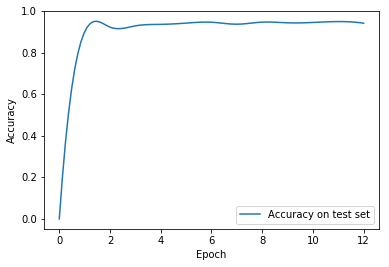

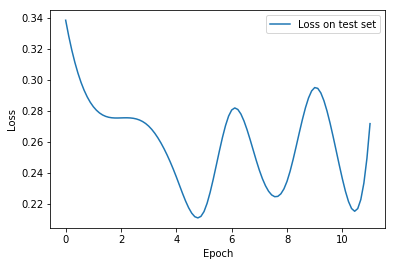

In [7]:
plot_learing_progress('./logs/acc-loss.csv')

In [8]:
# Checking results on test dataset one more time
with tf.Session() as sess:
    saver.restore(sess, './model/model.ckpt')
    t_acc, t_loss = evaluate(X_test, y_test, sess)
    print("Test accuracy: {:.2f}, loss: {:.2f}".format(t_acc, t_loss))

Test accuracy: 0.95, loss: 0.24


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

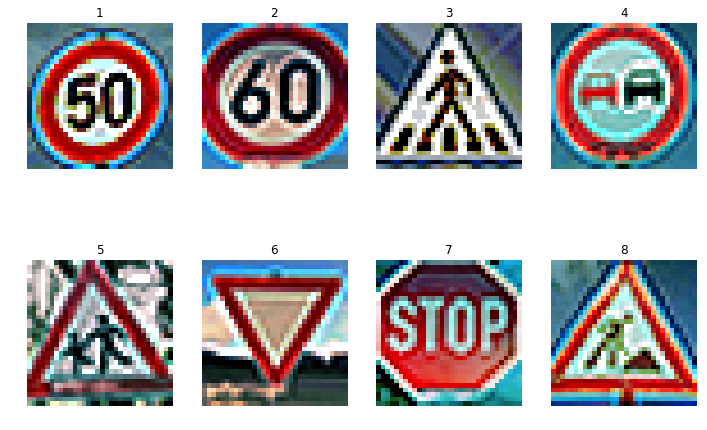

In [9]:
# Import traffic signs class names
signs_class = get_classes('signnames.csv')

# Import images from web
test_img, test_sign_class = load_test_images('./web/*.png', './web/signnames.csv')

# Visualize images from web
plot_test_images(test_img)

### Predict the Sign Type for Each Image

Accuracy on web: 0.88%


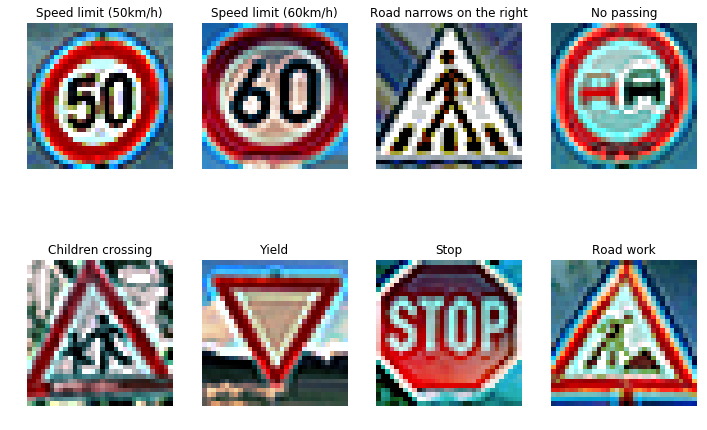

In [11]:
with tf.Session() as sess:
    saver.restore(sess, './model/model.ckpt')
    signs_classes = sess.run(
        tf.argmax(logits, 1),
        feed_dict={x: test_img.reshape((-1, 32, 32, 3)).astype(np.float32), keep_prob: 1.0}
    )
    acc = len(set(signs_classes).intersection(test_sign_class)) / len(test_img)
    print("Accuracy on web: {0:.2f}%".format(acc))

plot_test_images(test_img, signs_class = signs_class, signs_classes = signs_classes)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

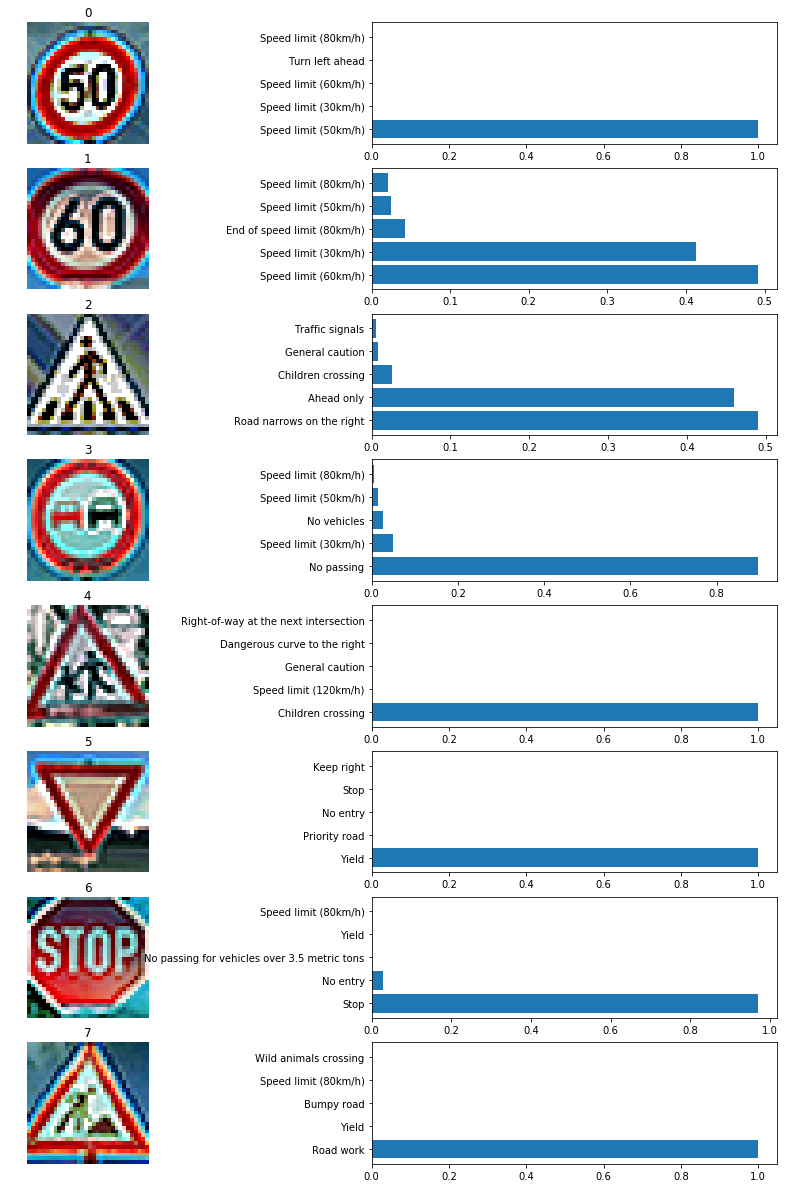

In [10]:
with tf.Session() as sess:
    saver.restore(sess, './model/model.ckpt')
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: test_img, keep_prob: 1.0})    
    top_5 = sess.run(tf.nn.top_k(prob, k = 5))
    plot_probabilities(test_img, top_5, signs_class)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


SIZE: 27


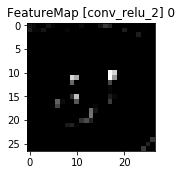

SIZE: 27


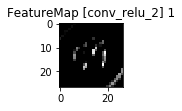

SIZE: 27


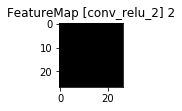

SIZE: 27


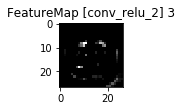

SIZE: 27


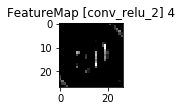

SIZE: 27


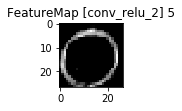

SIZE: 27


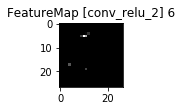

SIZE: 27


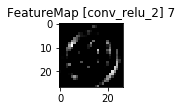

SIZE: 27


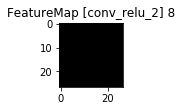

ValueError: num must be 1 <= num <= 9, not 10

In [33]:
def outputFeatureMap(image_input, title, tf_activation, activation_min = -1, activation_max = -1, plt_num = 1):
    activation = tf_activation.eval(session=sess, feed_dict={x: test_img, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(12, 8))
    for featuremap in range(featuremaps):
        plt.subplot(3, 3, featuremap + 1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap [' + title + '] ' + str(featuremap)) # displays the feature map number
        print("SIZE: {}".format(len(activation[0,:,:, featuremap])))
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation = 'nearest', vmin = activation_min, vmax = activation_max, cmap = 'gray')
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation = 'nearest', vmax = activation_max, cmap = 'gray')
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation = 'nearest', vmin = activation_min, cmap = 'gray')
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation = 'nearest', cmap = 'gray')
        plt.show()
        
with tf.Session() as sess:
    saver.restore(sess, './model/model.ckpt')
    #outputFeatureMap(test_img, 'conv_relu_1', sess.graph.get_tensor_by_name('conv_relu_1:0'))
    outputFeatureMap(test_img, 'conv_relu_2', sess.graph.get_tensor_by_name('conv_relu_2:0'))
    #outputFeatureMap(test_img, 'maxpool_1', sess.graph.get_tensor_by_name('maxpool_1:0'))